In [1]:
import os
import glob
import pickle
import warnings
import numpy as np
from scipy import io
from mne import viz, stats
from matplotlib import colors, cm, gridspec, pyplot as plt

plt.style.use("seaborn-dark")
plt.rcParams.update({"xtick.labelsize": 15, "ytick.labelsize": 15})

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
CAF_DOSE = 200 # the caffeine dose in mg (200 or 400)
AGE_GROUP = 0 # -1: all, 0: up to age 30, 1: from age 30
AVG_FEATURES = False # if True, uses results from averaged features

SIGNIFICANT_P = 0.05 # weak significance threshold (grey dots)
SIGNIFICANT_P_STRONG = 0.01 # strong significance threshold (white dots)

PROJECT_PATH = '../data' # path to where the EEG sensor position file is stored
RESULTS_PATH = f'../results/final/singleML{CAF_DOSE}' # directory where statistics results get stored
FIGURE_PATH = '../figures' # directory where the figures are saved

STAGES = ['NREM', 'REM'] # sleep stages to include in the figure
BANDS = ['delta', 'theta', 'alpha', 'sigma', 'beta', 'low gamma'] # frequency bands to include in the figure
FEATURES = ["PSD_delta", "PSD_theta", "PSD_alpha", "PSD_sigma", "PSD_beta", "PSD_low gamma",
            "SpecShanEn", "SampEn", "SpecSampEn", "LZiv", "DFA", "OneOverF"] # list of features

delete_classifiers = [] # which classifiers to remove from the figures
delete_features = [] # which features to remove from the figures

In [3]:
def fmt_feat(name):
    return name.replace("PSD", "").replace('_', ' ').replace('Shan', '').replace("LZiv", "Lempel-Ziv").replace("OneOverF", f"aperiodic slope")

# Load data

In [4]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

## Load classification results and correct for multiple comparisons
Loads classification scores and statistics and corrects for multiple comparisons with maximum statistics. Scores is a nested dictionary of classifiers, sleep stages and features containing a list of results for each channel. The results are a tuple of classification accuracy, permutation scores and two accuracy thresholds for weak (p < 0.05) and strong (p < 0.01) significance.

In [5]:
# get age suffix for loading the data depending on age group parameter
age_suffix = ''
if AGE_GROUP == 0:
    age_suffix = '_age_t30'
elif AGE_GROUP == 1:
    age_suffix = '_age_f30'
elif AGE_GROUP != -1:
    raise Exception(f"Unknown age group {AGE_GROUP}")

avg_suffix = "_avg" if AVG_FEATURES else ""

# load classification results
scores = {}
for path in glob.glob(os.path.join(RESULTS_PATH, f'scores_*{avg_suffix}{age_suffix}.pickle')):
    if AGE_GROUP == -1 and "age" in path.split(os.sep)[-1]:
        continue
    if not AVG_FEATURES and "avg" in path.split(os.sep)[-1]:
        continue
    clf = path.split(os.sep)[-1].split('.')[0].split('_')[1]
    with open(path, 'rb') as file:
        scores[clf] = pickle.load(file)
        
        # potentially delete some features
        for stage in scores[clf].keys():
            for ft in delete_features:
                if ft in scores[clf][stage]:
                    del scores[clf][stage][ft]

# potentially remove some data
for delete in delete_classifiers:
    if delete in scores:
        del scores[delete]

# correct for multiple comparisons with maximum statistics
for clf in scores.keys():
    for stage in scores[clf].keys():
        for feat in scores[clf][stage].keys():
            # get maximum accuracies across channels
            permutations = [scores[clf][stage][feat][elec][1] for elec in range(len(scores[clf][stage][feat]))]
            permutations = np.sort(np.array(permutations).max(axis=0))

            # compute corrected accuracy thresholds
            threshold = permutations[-int(permutations.shape[0] * SIGNIFICANT_P + 1)]
            threshold_strong = permutations[-int(permutations.shape[0] * SIGNIFICANT_P_STRONG + 1)]

            # save new thresholds
            for elec in range(len(scores[clf][stage][feat])):
                scores[clf][stage][feat][elec] = list(scores[clf][stage][feat][elec])
                scores[clf][stage][feat][elec][-1] = threshold
                scores[clf][stage][feat][elec] += [threshold_strong]

# Create figures

## Topomap summary figure

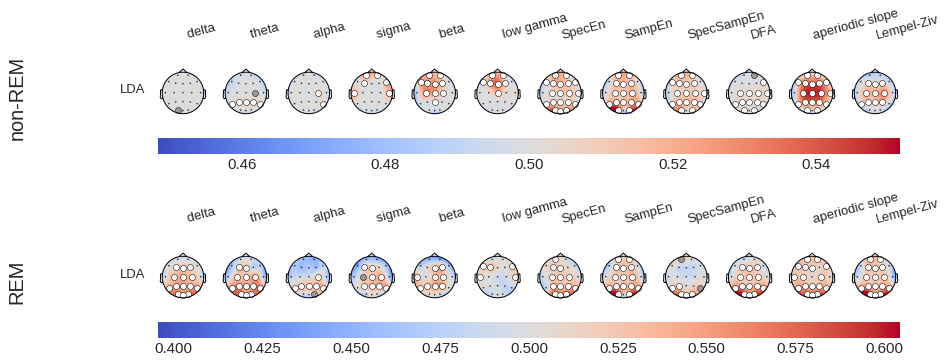

In [6]:
colormap = 'coolwarm'
fontsize_small = 13
fontsize_big = 20

# create gridspec
rows_per_stage = (len(scores) + 3)
gs = gridspec.GridSpec(rows_per_stage * len(STAGES) - 1,
                       len(scores[list(scores.keys())[0]][STAGES[0]]) + 2,
                       width_ratios=[1.5, 1] + [1] * len(scores[list(scores.keys())[0]][STAGES[0]]),
                       height_ratios=(([0.015] + [1] * len(scores) + [0.2, 0.7]) * len(STAGES))[:-1],
                       wspace=0.25,
                       hspace=0.2)
# skip stage annotation plot and empty top left subplot
subplot_counter = 2

plt.figure(figsize=(16, len(scores) * 3 + 2))

for stage_index, stage in enumerate(STAGES):
    # add current stage annotations
    plt.subplot(gs[stage_index*rows_per_stage:(stage_index+1)*rows_per_stage-1,0])
    plt.axis('off')
    plt.annotate(stage.replace('AWSL', 'awake').replace('NREM', 'non-REM'),
                 xy=(0, 0.5),
                 ha='left',
                 va='center',
                 rotation=90,
                 fontsize=fontsize_big)

    # add feature name annotations
    for feature in scores[list(scores.keys())[0]][stage].keys():
        plt.subplot(gs[subplot_counter])
        subplot_counter += 1
        
        name = fmt_feat(feature)
        plt.annotate(name,
                     xy=(0.5, 1),
                     ha='left',
                     va='bottom',
                     rotation=15,
                     fontsize=fontsize_small)
        plt.axis('off')
    
    # calculate min and max values for plots and colormaps
    vmin = min([min([min([scores[clf][stage][feature][electrode][0] for electrode in range(20)]) for feature in scores[clf][stage].keys()]) for clf in scores.keys()])
    vmax = max([max([max([scores[clf][stage][feature][electrode][0] for electrode in range(20)]) for feature in scores[clf][stage].keys()]) for clf in scores.keys()])
    diff = max(abs(0.5 - vmin), abs(0.5 - vmax))
    vmin = 0.5 - diff
    vmax = 0.5 + diff
    
    for clf in sorted(scores.keys()):
        # skip stage text subplot
        subplot_counter += 1
        
        # add classifier name annotations
        for feature in scores[clf][stage].keys():
            if subplot_counter % gs._ncols == 1:
                plt.subplot(gs[subplot_counter])
                subplot_counter += 1
                
                plt.annotate(clf.replace('nP', 'n\nP'), xy=(1, 0.5), ha='right', va='center', fontsize=fontsize_small)
                plt.axis('off')
            
            # get data for plotting
            acc = [score[0] for score in scores[clf][stage][feature]]
            threshold = np.array([score[2] for score in scores[clf][stage][feature]])
            threshold_strong = np.array([score[3] for score in scores[clf][stage][feature]])
            
            plt.subplot(gs[subplot_counter])
            subplot_counter += 1
            
            mask = acc >= threshold
            mask_strong = acc >= threshold_strong
            
            marker_colors = [[0.6, 0.6, 0.6]] * len(mask)
            for i, significant in enumerate(mask_strong):
                if significant:
                    marker_colors[i] = 'w'
            marker_colors = np.array(marker_colors)[mask]
                
            # plot topomap
            viz.plot_topomap(acc,
                             sensor_pos,
                             mask=mask,
                             vmin=vmin,
                             vmax=vmax,
                             cmap=colormap,
                             mask_params={'markersize': 6, 'markeredgewidth': 0.5, 'markerfacecolor': marker_colors},
                             contours=False,
                             show=False)
    
    # add colorbar
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, cax=plt.subplot(gs[(stage_index+1)*rows_per_stage-2,2:]), orientation='horizontal')
    
    # add space below plot
    if stage_index < len(STAGES) - 1:
        plt.subplot(gs[(stage_index+1)*rows_per_stage-1,2:])
        plt.axis('off')
    subplot_counter += gs._ncols * 2 + 2

plt.show()

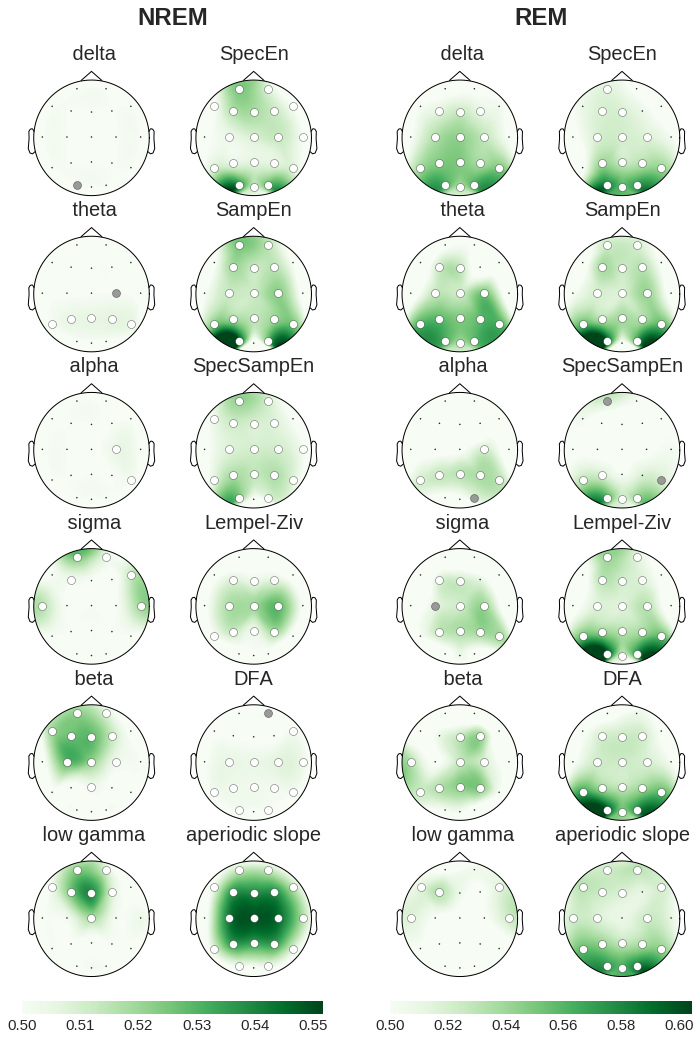

In [7]:
cmap = "Greens"
fontsize_small = 20
fontsize_big = 24
clf = "LDA"

n_feat = len(FEATURES)
fig, axes = plt.subplots(n_feat // 2 + 1, len(STAGES) * 2 + len(STAGES) - 1, figsize=(12, 16),
                         gridspec_kw=dict(width_ratios=([0.15, 1, 1] * len(STAGES))[1:],
                                          height_ratios=[1] * (n_feat // 2) + [0.1]))
gs = axes[0,0].get_gridspec()

# remove last row of axes
for ax in axes[-1,:]:
    ax.remove()
# add per-stage colorbar axes
colorbar_axes = []
for i in range(len(STAGES)):
    colorbar_axes.append(fig.add_subplot(gs[-1, i * 2 + i : (i + 1) * 2 + i]))
# remove spacing columns
for i in range(1, len(STAGES)):
    for ax in axes[:-1, i * 3 - 1]:
        ax.remove()

for i_stage, stage in enumerate(STAGES):
    # add sleep stage titles
    x_text = np.mean([
        (ax.get_position().x0 + ax.get_position().x1) / 2
        for ax in axes[0, i_stage * 2 + i_stage: (i_stage + 1) * 2 + i_stage]]
    )
    fig.text(x_text, 0.98, stage, fontsize=fontsize_big, weight="bold", ha="center", va="bottom")

    vmin = 0.5
    vmax = max([max([scores[clf][stage][feat][i][0] for i in range(20)]) for feat in FEATURES])
    for i_feat, feat in enumerate(FEATURES):
        score = np.array([s[0] for s in scores[clf][stage][feat]])
        sig_thresh = np.array([s[2] for s in scores[clf][stage][feat]])
        sig_thresh_strong = np.array([s[3] for s in scores[clf][stage][feat]])
        
        # get significance marker params
        mask = score > sig_thresh
        marker_colors = [[0.6, 0.6, 0.6]] * len(mask)
        for i in np.where(score > sig_thresh_strong)[0]:
            marker_colors[i] = 'w'
        marker_colors = np.array(marker_colors)[mask]
        
        # plot topomaps
        ax = axes[i_feat % (n_feat // 2), i_feat // (n_feat // 2) + (i_stage * 3)]
        viz.plot_topomap(score,
                         sensor_pos,
                         axes=ax,
                         mask=mask,
                         vmin=vmin,
                         vmax=vmax,
                         mask_params={'markersize': 8, 'markeredgewidth': 0.3, 'markerfacecolor': marker_colors},
                         cmap=cmap,
                         contours=False,
                         show=False)
        ax.set_title(fmt_feat(feat), fontsize=fontsize_small)
    
    mappable = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    fig.colorbar(mappable, cax=colorbar_axes[i_stage], orientation="horizontal")

plt.savefig(os.path.join(FIGURE_PATH, "SupFigure1.pdf"), bbox_inches="tight", transparent=True)
plt.show()